In [132]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import time
import math
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [167]:
class NN(nn.Module):
    def __init__(self,):
        super(NN, self).__init__()
        #Linear layers
        self.mod = nn.Sequential(
            nn.Linear(1, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, inpu):
        out = self.mod(inpu)
        return out

In [185]:
class Model:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)
        
        #Max iteration
        self.max_iter = 1000
        
        #Criterion for loss 
        self.criterion = nn.MSELoss()
        
        #Optimizer
        self.optimizer = optim.Adam(self.model.parameters())
        
        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        #Initialization for training
        self.t_step = 0.001
        t = torch.arange(0, 15 + self.t_step, self.t_step) #create grid for t-axis
        
        #Create grid for solution
        self.grid = t.reshape(1, -1).T.to(device)  # no need to create grid for 1D problem
        self.grid.requires_grad = True
        
        #Training data
        initial = torch.tensor([t[0]]*len(t)) # Points for boundary conditions (both are same)
        
        self.train_points = initial.reshape(1, -1).T.to(device) # Training points as a grid
        self.train_points.requires_grad = True
        
        self.u_initial = torch.ones(len(initial)).reshape(1,-1).T.to(device)
        self.ut_initial = -1*torch.ones(len(initial)).reshape(1,-1).T.to(device)

        """
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        """
        self.iter = 1


    
    def loss(self):
        self.lbfgs.zero_grad()
        
        y = self.model(self.train_points) 
        dy_dt = torch.autograd.grad(inputs=self.train_points, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        
        loss = self.criterion(y, self.u_initial) #Compute first part of loss
        loss += self.criterion(dy_dt, self.ut_initial) #Compute second part of loss
        
        u = self.model(self.grid)
        #Compute gradients of grid with respect to t
        du_dt = torch.autograd.grad(inputs=self.grid, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt2 = torch.autograd.grad(inputs=self.grid, outputs=du_dt, grad_outputs=torch.ones_like(du_dt), retain_graph=True, create_graph=True)[0]

        loss += self.criterion(du_dt2 + 2*du_dt + u, torch.exp(-self.grid)*torch.cos(2*self.grid)) #third part of loss, using f(t,x) as in paper
        
        loss.backward()
        #Print loss every 100 iteration
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        for i in range(self.max_iter):
            self.optimizer.step(self.loss)
        #self.lbfgs.step(self.loss)


In [186]:
model = Model()
model.train()

100 0.01549999974668026
200 0.001009010593406856
300 0.00042169788503088057
400 0.0002993313828483224
500 0.0002379303623456508
600 0.00020132161444053054
700 0.00017773531726561487
800 0.00016106796101666987
900 0.0001483251980971545
1000 0.00013808382209390402


tensor(1.7603e-05)


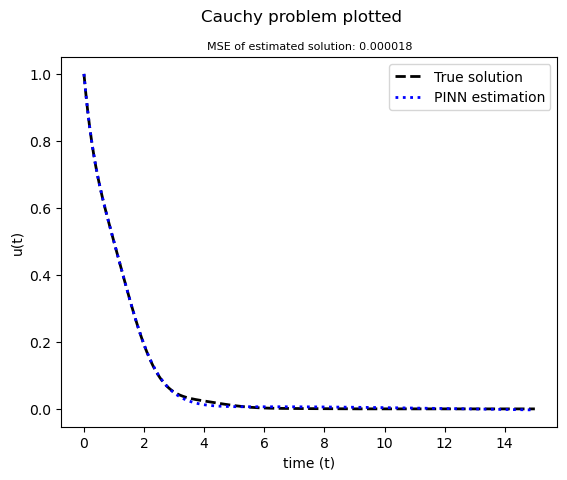

In [211]:
def result_funct(t):
    return (5/4)*torch.exp(-t) - (1/4)*torch.exp(-t)*torch.cos(2*t)

time_step = 0.001
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
time = torch.arange(0, 15 + time_step, time_step).reshape(1,-1).T.to(device)


mod = model.model
mod.eval()
with torch.no_grad():
    y_pred = mod(time).cpu()

mse = nn.MSELoss()
error = mse(y_pred, result_funct(time))

fig, ax = plt.subplots()
ax.plot(time, result_funct(time), color='black',linestyle='--', linewidth=2, label='True solution')
ax.plot(time, y_pred, color='blue', linestyle=':', linewidth=2, label='PINN estimation')
ax.legend()
plt.suptitle("Cauchy problem plotted")
plt.title("MSE of estimated solution: %f" %error, fontsize=8)
plt.xlabel("time (t)")
plt.ylabel("u(t)")
fig.show
print(error)